# Vectorized Multi-Class Classification 3-Layer Neural Network with Regularization using Gradient Descent in Python

This is an example of a small 3-layer vectorized neural network.

The data used in this example is 5,000 examples of hand written digits (0-9) that have been collected as a 20x20 pixel image. The pixels have been 'unrolled' into a 5,000 x 400 matrix. 

The neural network will have to correctly identify 10 digits. The known data will be imported into the "y" variable and the image data will be imported into the "x" variable. The theta values that will be used in this demonstration will be randomly initialized.

Now to import the data and required libraries for the demonstration.

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
%matplotlib inline  


mat_contents = sio.loadmat("C:\\Users\\bryantcm\\Downloads\\ex4data1.mat")    

# Numpy arrays of x (features), y (outcome), and m (number of observations)
x = np.matrix(mat_contents['X'])
y = np.matrix(mat_contents['y'])
yVec = np.matrix(pd.get_dummies(np.array(y)[:,0]))
m = len(x)

# First have to add the bias paramater for the x matrix
x = np.append(np.ones([len(x), 1]), x, 1)

mat2_contents = sio.loadmat("C:\\Users\\bryantcm\\Downloads\\ex4weights.mat")
Theta1 = np.matrix(mat2_contents['Theta1'])
Theta2 = np.matrix(mat2_contents['Theta2'])

Although the data is in a matrix format, the data can be reconstructed for visualization to see the images that are being worked with. The next cell will reconstruct the matrix into a visualization of the images.

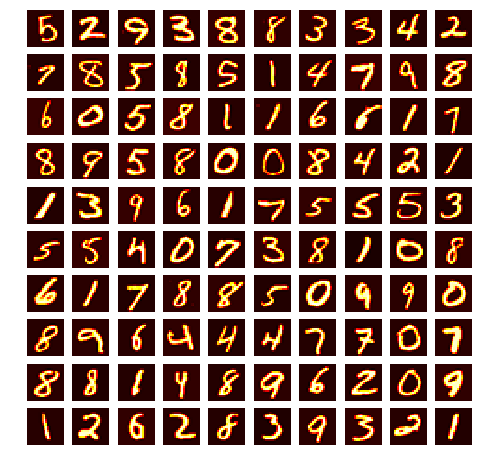

In [2]:
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(x[:, 1:][np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

Excellent! The neural network will classify the numbers that range from 0-10. The next steps will do the following: <br>
<br>
> 1) Create a sigmoid activation function <br>
2) Create a sigmoid gradient function <br>
3) Create the neural network cost function <br>
4) Create a function to create randomly initialized weights <br>
5) Create the function that will combine these other functions to compute Gradient Descent

## 1 and 2. Creating the sigmoid activation function and the sigmoid gradient function

These functions are used in the layer activation and assessment steps of the overall algorithm.

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoidGradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

## 3. The Neural Network
This *nnCostFunction* performs the forward propogation steps of the neural network and returns the cost function as well as the thetas, $\theta$s, gradient. In this example, the neural network will only be comprised of 3 layers (input layer, layer 2 [hidden layer], and layer 3 [the output layer]). Therefor, there will be 2 theta matrices that will need to be calculated.

Additionally, this neural network function is designed to be regularized if that is desired. If not, pass "0" into the *lmda* method parameter.

In [4]:
# Neural Network Cost Function
def nnCostFunction(theta1, theta2, num_labels, X, y, lmbda):
    
    Theta1 = theta1
    Theta2 = theta2
    
    Theta1_grad = 0
    Theta2_grad = 0
    
    m = X.shape[0]
    J = 0
    
    
    ## Forward Propogation
    layer_z2 = x*Theta1.T
    layer_a2 = sigmoid(layer_z2)

    layer_a2 = np.append(np.ones([len(layer_a2), 1]), layer_a2, 1)

    layer_z3 = layer_a2*Theta2.T
    layer_a3 = sigmoid(layer_z3)

    ## Cost
    J = (1/m) * np.sum(np.sum(np.multiply((-1*yVec), np.log(layer_a3)) - \
                          np.multiply((1 - yVec), np.log(1 - layer_a3)))) \
    + lmbda/(2*m) * (np.sum(np.sum(np.power(Theta1[:, 1:], 2))) + \
                     np.sum(np.sum(np.power(Theta2[:, 1:], 2))))
    
    

    # This computes the error between the last layer (contains prediction) and the known output 
    delta_3 = layer_a3 - yVec

    # This computes the error between layer 2 and layer 3
    delta_2 = np.multiply((delta_3 * Theta2), 
                          np.append(np.ones([len(sigmoidGradient(layer_z2)), 1]), 
                                    sigmoidGradient(layer_z2), 1))
    delta_2 = delta_2[:, 1:]

    Theta1_grad = Theta1_grad + (1/m) * (delta_2.T * x) + (lmbda/m) * np.append(np.zeros([len(Theta1), 1]), Theta1[:, 1:], 1)
    Theta2_grad = Theta2_grad + (1/m) * (delta_3.T * layer_a2) + (lmbda/m) * np.append(np.zeros([len(Theta2), 1]), Theta2[:, 1:], 1)
    
    
    return J, Theta1_grad, Theta2_grad 

## 4. Randomly Initializing Weights

These are the theta parameters that will be randomly initialized. For reproducability I included a *seed* parameter that will set the seed for numpy when it's called to produced the random numbers.

In [5]:
## Randomly Initializing Weights Function
def randInitializeWeights(layer_size_in, layer_size_out, seed= 0):
    """
    Randomly initializes the weights of a layer with a specified number 
        of incoming connections and outgoing connections. Where:
            layer_size_in is the number of incoming connections, and
            layer_size_out is the number of outgoing connections
    """
    
    np.random.seed(seed)
    
    epi = (6**1/2) / (layer_size_in + layer_size_out)**1/2
    
    W = np.random.rand(layer_size_out, layer_size_in + 1) * (2*epi) - epi
    
    return W

# Randomly initializing the different layer thetas
initial_Theta1 = randInitializeWeights(x[:, 1:].shape[1], 25)
initial_Theta2 = randInitializeWeights(25, 10)

## 5. The Gradient Descent

This is the step that combines all the previous functions. The gradient descent is where the neural network learns and improves it's performance.

A few special parameters that should be passed are alpha, which sets the learning rate, lmbda, which is the penalization parameter for the cost function, and the number of iterations that is desired.

In [6]:
def gradientDescentnn(X, y, Theta1, Theta2, alpha, num_iters,
                     lmbda, num_labels):
    
    m = y.shape[0]
    J_history = []
    
    for i in range(num_iters):
        #nnCostFunction(theta1, theta2, num_labels, X, y, lmbda)
        cost, Theta1_grad, Theta2_grad = nnCostFunction(Theta1, Theta2, num_labels, X, y, lmbda)
        Theta1 = Theta1 - (alpha * Theta1_grad)
        Theta2 = Theta2 - (alpha * Theta2_grad)
        J_history.append(cost)
    
    return Theta1, Theta2, J_history

In [7]:
Theta1_f, Theta2_f, J_history = \
    gradientDescentnn(x, y, initial_Theta1, initial_Theta2, 0.8, 2000, 1, 10)

Now to check that the algorithm learned through each iteration. If learning occured, there will be a clear decrease in the cost function.

Text(0.5,0,'Number of Iterations')

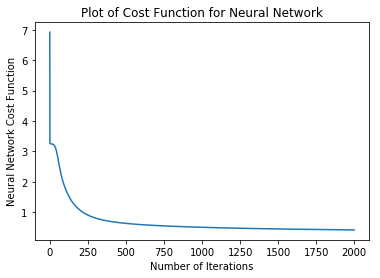

In [8]:
ax = pd.DataFrame(J_history).plot(title= "Plot of Cost Function for Neural Network",
                             legend= False)

ax.set_ylabel("Neural Network Cost Function")
ax.set_xlabel("Number of Iterations")

The plot indicates that as each iteraction occured the neural network had a decrease in the cost function which indicates that performance was improved through every iteraction. Now to predict outcomes using the trained thetas.

In [9]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    
    layer_z2 = X*Theta1.T
    layer_a2 = sigmoid(layer_z2) 

    layer_a2 = np.append(np.ones([len(layer_a2), 1]), layer_a2, 1)

    layer_z3 = layer_a2*Theta2.T
    layer_a3 = sigmoid(layer_z3)
    
    return layer_a3

In [10]:
# Generating predictions based on trained Thetas
predictions = predict(Theta1_f, Theta2_f, x).round(0)

# Have to get y labels into a matrix were each column represents a digit
yVec = pd.get_dummies(pd.DataFrame(y, dtype= 'str'))

yVec = yVec[['0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10']]



from sklearn.metrics import accuracy_score

print("Neural netowrk achieved an accuracy score of",
      f"{accuracy_score(yVec, predictions) * 100: 0.1f}%.")

Neural netowrk achieved an accuracy score of  93.2%.


The neural network achieved 93.2% accuracy with regularization - that's pretty good performance for a first pass with the neural network. If increased performance is desired, could try different penalization values and/or different activation functions. Another avenue to pursue would be to look at the cases where the outcome was miss-classified and try to identify features in those cases that would be included in the model.